# IEOR 4571 Final Project

### Group Member: Jialei Wang, Hantang Zhou
### Dec 21st, 2018

# 0. Data Set

Link to the data set: [Anime Recommendations Database](https://www.kaggle.com/CooperUnion/anime-recommendations-database)

There is official explanation of each column in the data.
Dataset Anime:
- Column anime_id: integer, myanimelist.net's unique id identifying an anime.
- Column name: string, full name of anime.
- Column genre: string, comma separated list of genres for this anime.
- Column type: string, movie, TV, OVA, etc.
- Column episodes: integer, how many episodes in this show. (1 if movie).
- Column rating: float, average rating out of 10 for this anime
- Column members: integer, number of community members that are in this anime's "group"

Dataset Rating:
- Column user_id: integer, non identifiable randomly generated user id.
- Column anime_id: integer, the anime that this user has rated.
- column rating: integer, rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

The objective of our project is to find the best FM model to give predictions and recommendations to user. We evaluate the model through auc score , coverage and level of serendipity.

# 1. Pre-processing Data <br/>
Here we import everything needed, including packages and datasets. We also subset the data and remove invalid ratings.

In [2]:
import pandas as pd
import numpy as np
import math
import scipy.sparse
from lightfm import LightFM
from lightfm import cross_validation
from lightfm.evaluation import *

anime = pd.read_csv('anime-recommendations-database/anime.csv')
rating = pd.read_csv('anime-recommendations-database/rating.csv')

/Users/catherine/anaconda3/lib/python3.6/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [3]:
MAX_ITEM = 12294
MAX_USER = 73515
numUser = math.floor(MAX_USER*0.5)
numItem = math.floor(MAX_ITEM*0.5)

rating_sample = rating[rating["user_id"].isin(range(1,numUser+1))]
rating_sample = rating_sample[rating_sample["anime_id"].isin(range(1,numItem+1))]
rating_sample = rating_sample[rating_sample.rating != -1].sample(frac=1).reset_index(drop=True)

ani_sample = anime[anime["anime_id"].isin(range(1,numItem+1))]

In [4]:
# get subsets, which is ordered by the number of reviews of the users
# mats[0] is the group of users with least review, while mats[9] is the most reviews
s = rating_sample[['user_id', 'anime_id']].groupby('user_id').count()
s = s.sort_values(by=['anime_id'])
mats = np.array_split(s, 10)

In [13]:
# Here we create the interaction matrix and item feature matrix
# the include_* specify which side information to include
# the default is to include all the information
def getMatrix(m, include_episodes=True, include_type=True, include_rating=True, include_genre=True, include_members=True):
    mat = rating_sample[rating_sample['user_id'].isin(m.index.values)]
    ## interaction
    R_df = mat.pivot(index = 'user_id', columns = 'anime_id', values = 'rating').fillna(0)
    interaction = scipy.sparse.coo_matrix(R_df.values)
    int_train,int_test = cross_validation.random_train_test_split(interaction, test_percentage=0.2, random_state=None)
    ## item feature
    test = ani_sample[ani_sample['anime_id'].isin(mat['anime_id'].unique())]
    test = test.sort_values(by=['anime_id']).set_index('anime_id')

    aniType = pd.get_dummies(test['type'])
    genre = test['genre'].str.get_dummies(sep=',')
    epi = test['episodes'].replace({'Unknown': None})
    epi = pd.to_numeric(epi)
    epi = epi.replace({None: epi.mean()})
    epi = (epi-epi.mean())/epi.std()
    avgRating = test['rating'].fillna(test['rating'].mean())
    members = test['members'].fillna(test['members'].mean())
    members = (members-members.mean())/members.std()

    item_feature = None
    if not include_episodes and not include_type and not include_rating and not include_genre and not include_members:
        item_feature = None
    else:
        if not include_episodes:
            epi = None
        if not include_type:
            aniType = None
        if not include_rating:
            avgRating = None
        if not include_genre:
            genre = None
        if not include_members:
            members = None
        item_feature = pd.concat([genre,aniType,epi,avgRating,members],axis=1)
        item_feature = scipy.sparse.csr_matrix(item_feature.values)
    
    return (int_train,int_test,item_feature)

# 2. Setup model

In [15]:
model = LightFM(loss='warp')

We first start with FM with out side effect. This is the same as Matrix factorization problem. So we set this problem as a baseline.

In [35]:
preAtK = []
for m in mats:
    int_train,int_test,_ = getMatrix(m)
    model.fit(int_train, epochs=30)
    test_precision = precision_at_k(model, int_test, int_train, k=5).mean()
    print(test_precision)
    preAtK.append(test_precision)

0.04727955
0.054747954
0.07645705
0.09938373
0.1340727
0.16850062
0.21679206
0.27411202
0.34244433
0.48911607


We chose precision at k as our metric since we are dealing with a ranking problem. </br>
From the above data we can see that the precision at level k is increasing when the density of the matrix is increasing. However, during the project, we also tried to use auc score as our metric. Though not shown above, auc scores are around 0.8~0.9 and reached a peak at density level 2% and start to decrease when we increase density. We guess this is because of overfitting.

In [11]:
def getPercent(m):
    fill = sum(m['anime_id'])
    userNum = len(m.index.unique())
    ratingSam = rating_sample[rating_sample['user_id'].isin(m.index.values)]
    itemNum = len(ratingSam['anime_id'].unique())
    percentage = fill / (userNum*itemNum)
    return percentage

In [12]:
# Percentage of filling at mats[8]. This is where auc score begin to decrease.
getPercent(mats[8])

0.024145347054560656

In [13]:
import time
timeL = []
for m in mats:
    start = time.time()
    int_train,int_test,item_feature = getMatrix(m)
    model.fit(int_train, epochs=30)
    stop = time.time()
    duration = stop-start
    print(duration)
    timeL.append(duration)

1.0823981761932373
1.7669618129730225
2.3115739822387695
3.3566360473632812
4.28491997718811
5.912028074264526
7.673192977905273
10.422170877456665
15.668450117111206
38.821571826934814


In [14]:
dens = []
for m in mats:
    dens.append(getPercent(m))

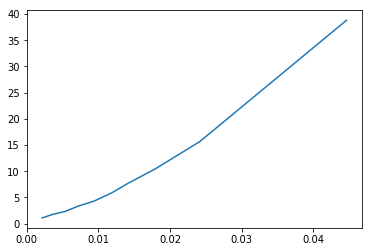

In [16]:
import matplotlib.pyplot as plt
plt.plot(dens, timeL)
plt.show()

From the above plot we can see that when the density of the graph increases, the time taken for FM to fit also increases. They have a linear relationship. In addition, we have shown that if the density of the matrix go beyond 2%, it will cause overfitting. Here I used 3335 users in one data subset and at density 1.8% the fitting took around 10 sec which is acceptable. Thus it further proves a matrix with density around 2% would be best for FM.

# 3. Adding Side Information
After the above test, we add some side information into the model. As listed before, out dataset does not contain much side information of the users, but we do have some for the anime. Therefore, we begin to construct the item feature matrix. Here is a summary of what we did:

- Normalized the episodes and included it in the item feature matrix
- Build pivot table for the column type and included in the item feature matrix
- Extracts different genres from the column genre, and the build a pivot table and included in the item feature matrix
- Includes thr rating to the item feature matrix

We first break the genre string and extracts the different genres for the movies, and then build up a pivot table along with the column type. We normalize the episode as well. We then build up the item feature matrix and run the test again with the item feature matrix. Here is what we get:

In [36]:
# calculate the AUC for differentt groups of user. The group is ordered by the rating counts of the user
pre_w_side = []
for m in mats:
    int_train,int_test,item_feature = getMatrix(m)    
    model.fit(int_train, epochs=30,item_features=item_feature)
    test_precision = precision_at_k(model, int_test,int_train, k=5,item_features=item_feature).mean()
    print(test_precision)
    pre_w_side.append(test_precision)

0.03358209
0.049091976
0.058320493
0.07787553
0.09960014
0.13722408
0.17007828
0.21119806
0.25508732
0.38220084


Similar to the case without side information. After mats[7] the auc score start to decrease. This is again caused by overfitting.

In [19]:
timeL_side = []
for m in mats:
    start = time.time()
    int_train,int_test,item_feature = getMatrix(m)    
    model.fit(int_train, epochs=30,item_features=item_feature)
    stop = time.time()
    duration = stop-start
    print(duration)
    timeL_side.append(duration)

1.4633920192718506
2.4523890018463135
4.1317431926727295
6.354115962982178
9.48148775100708
10.943519115447998
14.992868900299072
20.319350957870483
32.06664705276489
81.9001190662384


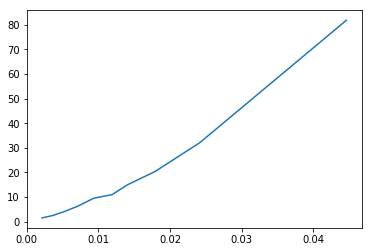

In [20]:
plt.plot(dens, timeL_side)

As we start to add in side infomation, the slope of the plot become very steep. In this case, though 1.8%density gives the best auc score, companies migh want to use lower density to around 1.5%(mats[6]) which lowers running time while the auc score did not decrease too much.

As we can see from the above result, the perfect score for precision at k is 1.0. The performance with side information is not as good as that without side information. 

We did not expect to see this result, so we tried to find out why. Here are some of the approach we tried:

## a. Drop Some Side Information

We are supposing that some of the side information we threw in the model is not helpful. So we tried to drop some of the side information.

At first, we include four side information:
- genre
- type
- episodes
- rating
- members

Now we tried to drop each of the information one at a time to see the outcome:

### i. drop genre

In [37]:
# calculate the AUC for different groups of user. The group is ordered by the rating counts of the user
pre_wo_genre = []
for m in mats:
    int_train,int_test,item_feature = getMatrix(m, include_genre = False)    
    model.fit(int_train, epochs=30,item_features=item_feature)
    test_precision = precision_at_k(model, int_test,int_train, k=5,item_features=item_feature).mean()
    print(test_precision)
    pre_wo_genre.append(test_precision)

0.030654205
0.044686962
0.053472225
0.07411003
0.091689676
0.12232306
0.14465523
0.18380494
0.22962072
0.3407697


As we can see from the above result, if we drop the genre and leave all other side effects there, the precision at k=5 indeed decreased significantly. So we conclude that the genre helps making the prediction.

### ii. drop type

In [38]:
# calculate the AUC for differentt groups of user. The group is ordered by the rating counts of the user
pre_wo_type = []
for m in mats:
    int_train,int_test,item_feature = getMatrix(m, include_type = False)    
    model.fit(int_train, epochs=30,item_features=item_feature)
    test_precision = precision_at_k(model, int_test, int_train,k=5,item_features=item_feature).mean()
    print(test_precision)
    pre_wo_type.append(test_precision)

0.03536122
0.04677138
0.061615
0.07828332
0.10073892
0.12786688
0.16092716
0.20680313
0.2524985
0.3644618


As we can see from the above result, if we drop the type and leave all other side effects there, the precision at k=5 is approximate the same. So we conclude that the type does not help making the prediction.

### iii. drop episodes

In [39]:
# calculate the AUC for differentt groups of user. The group is ordered by the rating counts of the user
pre_wo_episodes = []
for m in mats:
    int_train,int_test,item_feature = getMatrix(m, include_episodes = False)    
    model.fit(int_train, epochs=30,item_features=item_feature)
    test_precision = precision_at_k(model, int_test,int_train, k=5,item_features=item_feature).mean()
    print(test_precision)
    pre_wo_episodes.append(test_precision)

0.039033458
0.04350877
0.059214044
0.08153197
0.106128745
0.14124055
0.16857317
0.2059001
0.25436488
0.3623572


As we can see from the above result, if we drop the episodes and leave all other side effects there, the precision at k=5 is approximate the same. So we conclude that the episodes does not help making the prediction.

### iv. drop rating

In [41]:
# calculate the precision@k=5 for different groups of user. The group is ordered by the rating counts of the user
pre_wo_rating = []
for m in mats:
    int_train,int_test,item_feature = getMatrix(m, include_rating = False)    
    model.fit(int_train, epochs=30,item_features=item_feature)
    test_precision = precision_at_k(model, int_test,int_train, k=5,item_features=item_feature).mean()
    print(test_precision)
    pre_wo_rating.append(test_precision)

0.038794726
0.053962704
0.06857798
0.08920863
0.11155624
0.14158596
0.171764
0.21095727
0.25153524
0.35688514


As we can see from the above result, if we drop the rating and leave all other side effects there, the precision at k=5 decreased by a little. So we conclude that the rating has minor help making the prediction.

### v. drop members

In [42]:
# calculate the precision@k=5 for different groups of user. The group is ordered by the rating counts of the user
pre_wo_memeber = []
for m in mats:
    int_train,int_test,item_feature = getMatrix(m, include_members = False)    
    model.fit(int_train, epochs=30,item_features=item_feature)
    test_precision = precision_at_k(model, int_test, int_train,k=5,item_features=item_feature).mean()
    print(test_precision)
    pre_wo_memeber.append(test_precision)

0.03881701
0.040255964
0.045727305
0.061528496
0.07508469
0.10127351
0.122576766
0.15797713
0.18801929
0.29873723


As we can see from the above result, if we drop the members and leave all other side effects there, the precision at k=5 decreased significantly. So we conclude that the members helps making the prediction.

### vi. drop type, episodes

In [43]:
# calculate the precision@k=5 for differentt groups of user. The group is ordered by the rating counts of the user
pre_wo_type_episodes = []
for m in mats:
    int_train,int_test,item_feature = getMatrix(m, include_type = False, include_episodes= False)    
    model.fit(int_train, epochs=30,item_features=item_feature)
    test_precision = precision_at_k(model, int_test,int_train, k=5,item_features=item_feature).mean()
    print(test_precision)
    pre_wo_type_episodes.append(test_precision)

0.04174573
0.05127021
0.056678284
0.079403184
0.10027582
0.13414045
0.15851897
0.2087899
0.2510536
0.35069153


Since we experimented before, the type and episodes does not really help. However, after we remove them, the precision decrease as well.

### vii. drop type, episodes, rating

In [44]:
# calculate the precision@k=5 for differentt groups of user. The group is ordered by the rating counts of the user
pre_w_genre = []
for m in mats:
    int_train,int_test,item_feature = getMatrix(m, include_type = False, include_episodes= False, include_rating= False)    
    model.fit(int_train, epochs=30,item_features=item_feature)
    test_precision = precision_at_k(model, int_test,int_train, k=5,item_features=item_feature).mean()
    print(test_precision)
    pre_w_genre.append(test_precision)

0.038721804
0.053419057
0.06376812
0.08296008
0.108622275
0.13692169
0.16681722
0.19325708
0.23822999
0.3381239


Although droping the genre or members will give us a significantly less accuracy, only include these two factors as a side information still cannot give us a better performace than that including all the information.

### Conclusion For Dropping Side Information

It seems that although excluding some of the side information does not hurt the overal prediction accuracy, we still cannnot find a way to enhance the performance by dropping any of the side information. As a result, we believe that all of the side information indeed helps improve the performace.

## b. Normalize The Rating



In [45]:
def normalize_rating(rating):
    # replace the -1 with 0, 0 means the user did not rate thee anime
    rating = rating.replace(-1, 0)
    rating = rating[rating['rating'] != 0].copy()
    
    result = normalzie_Rating_Mapping(rating)
    
    rating_normalized = pd.merge(rating, result, on='user_id')
    rating_normalized['rating'] = (rating_normalized['rating'] - rating_normalized['mean'])/rating_normalized['std']
    rating_normalized = rating_normalized.drop(columns=['mean','std'])
    return result, rating_normalized

def normalzie_Rating_Mapping(rating):
    
    # get thee mean and std information
    ret = pd.merge(rating[['user_id', 'rating']].groupby('user_id').mean(),
                   rating[['user_id', 'rating']].groupby('user_id').std(), 
                   left_index=True, right_index=True)

    # replace the std from 0 to 1
    ret = ret.fillna(1)
    ret = ret.replace(0,1)
    
    ret = ret.rename(index=str, columns={"rating_x": "mean", "rating_y": "std"})
    ret['user_id'] = pd.to_numeric(ret.index)
    ret = ret.reset_index(drop=True)
    return ret

In [46]:
# normalize the rating data
rating = pd.read_csv('anime-recommendations-database/rating.csv')
rating_mapping, rating = normalize_rating(rating)

# recalculate the mats
rating_sample = rating[rating["user_id"].isin(range(1,numUser+1))]
rating_sample = rating_sample[rating_sample["anime_id"].isin(range(1,numItem+1))]
rating_sample = rating_sample[rating_sample.rating != -1].sample(frac=1).reset_index(drop=True)

s = rating_sample[['user_id', 'anime_id']].groupby('user_id').count()
s = s.sort_values(by=['anime_id'])
mats = np.array_split(s, 10)

### Run The Model Without Any Side Information And Normalized Rating

In [47]:
pre = []
for m in mats:
    int_train,int_test,item_feature = getMatrix(m)
    model.fit(int_train, epochs=30)
    test_precision = precision_at_k(model, int_test,int_train, k=5).mean()
    print(test_precision)
    pre.append(test_precision)

0.049713194
0.054947615
0.07293755
0.09676795
0.13509528
0.17562747
0.210295
0.26453945
0.3252258
0.49001804


### Run The Model With All Side Information And Normalized Rating

In [48]:
# calculate the AUC for differentt groups of user. The group is ordered by the rating counts of the user
pre_w_side = []
for m in mats:
    int_train,int_test,item_feature = getMatrix(m)    
    model.fit(int_train, epochs=30,item_features=item_feature)
    test_precision = precision_at_k(model, int_test,int_train, k=5,item_features=item_feature).mean()
    print(test_precision)
    pre_w_side.append(test_precision)

0.0389414
0.043667626
0.059626378
0.07769505
0.098404914
0.13535292
0.16266187
0.20939194
0.2609874
0.3758268


### Conclusion For Normalizing The Rating
As we can see from the above result, normalizing the rating indeed helps enhancing the performance of the model without side information. However, doing so does not really help the performance of the model with side information

## Conclusion For The Worse Performance With Side Information

As illustrated above, we tried many ways to enhance the performace of the model with the side information. However, as we can see, from the part "Dropping Some Side Information", adding a single piece of side information does not help. However, as we throw in more and more information, the precision indeed get better. Adding side information does not always lead to the increasing of the precision. Due to the limitation of the dataset we have, we are not able to get more side information for either the user or the item. We are guessing that the performace of the model with side information is positively correlated with the amount of side information we put in the model.

# 4. Coverage Analysis
In this part, we analyse the user and item coverage both with and without side information.

In [16]:
# calculate with side information using the whole set of user
int_train,int_test,item_feature = getMatrix(s)    
model.fit(int_train, epochs=100)

Since lightFM's prediction method returns a prediction score but not the prediction ratings, we define a score above 75% percentile as a high rating.

In [17]:
# find the 75% cutoff of the predicted values
all_prediction = []
for i in range(0, int_test.shape[0]):
    predicted = model.predict(i, np.arange(int_test.shape[1]))
    all_prediction.extend(predicted)
third_quantile = np.percentile(all_prediction, 75)


# item coverage & user coverage
item_coverage_list = []
user_coverage_count = 0
recon_good = third_quantile # define what is good for a recommend
user_good = 7 # define how much is good for command to a user
for i in range(0, int_test.shape[0]):
    # mask out the rated item for the user
    mask = np.asarray(int_test.getrow(i).todense()).flatten()
    predicted = model.predict(i, np.arange(int_test.shape[1]))
    predicted[mask != 0] = -1000
    recommend = predicted.argsort()[len(predicted)-10:]
    good_count = 0
    
    # go through the recommended list
    for i in recommend:
        if predicted[i] > recon_good:
            good_count = good_count + 1   
            
    # whether count as a good user
    if good_count >= user_good:
        user_coverage_count = user_coverage_count + 1
    item_coverage_list.extend(recommend)

item_coverage = len(np.unique(item_coverage_list))/int_test.shape[1]
print('The item coverage is: ' + str(item_coverage))

user_coverage = user_coverage_count/int_test.shape[0]
print('The user coverage is: ' + str(user_coverage))

The item coverage is: 0.16208092485549133
The user coverage is: 0.8853510823289561


From the above result, we can see that the item coverage is not very high. Here are the reasons we think might cause this problem: </br>
1. In the data set, we have a total of 4325 animes. From which our recommendation covers around 700 animes. Though this value is not as high as the gradient descent method we implemented for homework2, is relatively high compare to the "recommend the most popular" method. Considering the speed of running, we think this value is acceptable while can be improved using other rocommendation algorithms.
2. We defined a high rating as 75% percentile to mimic a score of 7.5/10 in the 1-10 rating scale. However, in such an approcimation, we have am implicit assumption that the rating is from a uniform distribution. However, from our rating sample, the ratings are highly skewed to the right, which implies a more approprate model might be a normal distribution. Our uniform assumption would cause the "high rating" standard being "higher" than 7.5/10.

In [19]:
# calculate with side information using the whole set of user
int_train,int_test,item_feature = getMatrix(s)    
model.fit(int_train, epochs=100,item_features=item_feature)

In [20]:
# find the 75% cutoff of the predicted values
all_prediction = []
for i in range(0, int_test.shape[0]):
    predicted = model.predict(i, np.arange(int_test.shape[1]), item_features=item_feature)
    all_prediction.extend(predicted)
third_quantile = np.percentile(all_prediction, 75)


# item coverage & user coverage
item_coverage_list = []
user_coverage_count = 0
recon_good = third_quantile # define what is good for a recommend
user_good = 7 # define how much is good for command to a user
for i in range(0, int_test.shape[0]):
    # mask out the rated item for the user
    mask = np.asarray(int_test.getrow(i).todense()).flatten()
    predicted = model.predict(i, np.arange(int_test.shape[1]), item_features=item_feature)
    predicted[mask != 0] = -1000
    recommend = predicted.argsort()[len(predicted)-10:]
    good_count = 0
    
    # go through the recommended list
    for i in recommend:
        if predicted[i] > recon_good:
            good_count = good_count + 1   
            
    # whether count as a good user
    if good_count >= user_good:
        user_coverage_count = user_coverage_count + 1
    item_coverage_list.extend(recommend)

item_coverage = len(np.unique(item_coverage_list))/int_test.shape[1]
print('The item coverage is: ' + str(item_coverage))

user_coverage = user_coverage_count/int_test.shape[0]
print('The user coverage is: ' + str(user_coverage))

The item coverage is: 0.09179190751445086
The user coverage is: 0.8470348384001919


# 5. References in analysis

In [25]:
# Showes how ratings are distributed
rating_sample[['user_id', 'rating']].groupby('rating').count()

,user_id
rating,
1,4295
2,5775
3,9570
4,24926
5,66997
6,145785
7,310223
8,367279
9,292421
